## Import Libraries

In [41]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, cross_validate, ShuffleSplit
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as XGBRegressor
from sklearn.model_selection import GridSearchCV
from numpy import absolute
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
import pickle
import category_encoders as ce
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor

### Functions

In [42]:
# R-squared and RMSE Function
def performance(y_true, y_predict):
    """ 
    Calculates and returns the two performance scores between 
    true and predicted values - first R-Squared, then RMSE
    """

    # Calculate the r2 score between 'y_true' and 'y_predict'
    r2 = r2_score(y_true, y_predict)

    # Calculate the root mean squared error between 'y_true' and 'y_predict'
    rmse = mean_squared_error(y_true, y_predict, squared=False)

    # Return the score
    return [r2, rmse]

# Importing Semi-Cleaned Data

In [43]:
df = pd.read_pickle('df_model')

Final clean to get ready for modeling

In [44]:
df = df.dropna(subset =['final_years', 'final_make'])
df =df.drop(['make','make_title', 'year', 'years', 'title_lower', 'URL', 'bikeTitle', 'attributes',], axis =1)
df = df[df['final_years'].astype(str).str.isdigit()]
df['odometer'] = df.odometer.str.extract('(^\d*)')
df[["final_years"]] = df[['final_years']].apply(pd.to_numeric)
df['Price']= df['Price'].apply(lambda x: x.replace('$',''))
df['Price']= df['Price'].apply(lambda x: x.replace(',',''))
df[['Price']] = df[['Price']].apply(pd.to_numeric)
df[['odometer']] = df[['odometer']].apply(pd.to_numeric)
df =df.reset_index(drop=True)
df = df[df['Price']<50000]
df=df[df['Price']>600]
df = df[df['odometer']<100000]
df = df[df['final_years']>1960]
df = df[df['final_years']<2022]
df.drop("VIN", inplace =True, axis =1)
df =df.reset_index(drop=True)
df['condition'] = df['condition'].str.replace('excellentcryptocurrency ok', 'excellent')
df['condition'] = df['condition'].str.replace('like newcryptocurrency ok', 'like new')
df['condition'] = df['condition'].str.replace('goodcryptocurrency ok', 'good')
df['condition'] = df['condition'].str.replace('faircryptocurrency ok', 'fair')
df['condition'] = df['condition'].str.replace('newcryptocurrency ok', 'new')
df['fuel'] = df['fuel'].fillna(value='other')
df['paint color'] = df['paint color'].fillna(value='other')
df['title status'] = df['title status'].fillna(value='other')
df['transmission'] = df['transmission'].fillna(value='other')
df['condition'] = df['condition'].fillna(value='other')
df['engine displacement (CC)'] = df['engine displacement (CC)'].fillna(value='other')
df['type'] = df['type'].fillna(value='other')
df = df[df['engine displacement (CC)']!='other']
df['engine displacement (CC)']= df['engine displacement (CC)'].astype(float)
bins = [0,250,500,750,1000,1250,1500,1750,2000, np.inf]
names =['0-250', '251-500', '501-750', '751-1000', '1001- 1250', '1251-1500', '1501-1750',' 1751-2000', '2001+']

df['engine_displacement'] = pd.cut(df['engine displacement (CC)'], bins, labels=names)
df=df.drop('engine displacement (CC)',axis=1)

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5045 entries, 3 to 12483
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   Price                5045 non-null   int64   
 1   title                5045 non-null   object  
 2   fuel                 5045 non-null   object  
 3   odometer             5045 non-null   float64 
 4   paint color          5045 non-null   object  
 5   title status         5045 non-null   object  
 6   transmission         5045 non-null   object  
 7   condition            5045 non-null   object  
 8   type                 5045 non-null   object  
 9   final_make           5045 non-null   object  
 10  final_years          5045 non-null   int64   
 11  engine_displacement  4999 non-null   category
dtypes: category(1), float64(1), int64(2), object(8)
memory usage: 478.3+ KB


# Train Test Split

In [46]:
# Use train_test_split to create training data and testing data
X = df.drop(['Price', 'title'], axis=1)
y = df['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

### Baseline Model

#### Using just odometer vs the price

/Users/avijames/anaconda3/lib/python3.8/site-packages/seaborn/regression.py:580: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


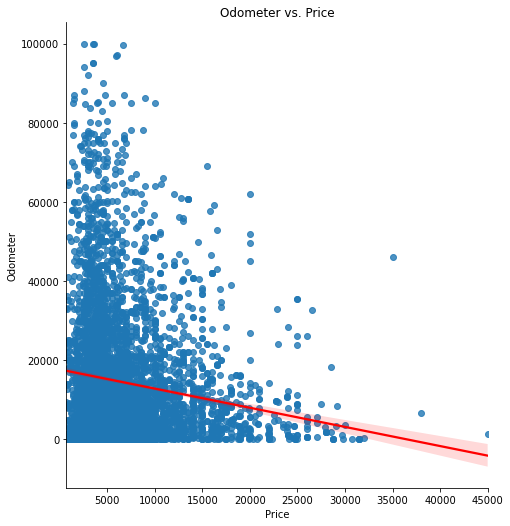

In [47]:
sns.lmplot(data=df, x='Price', y='odometer', size=7,line_kws={'color':'red'})
plt.xlabel('Price')
plt.ylabel('Odometer')
plt.title('Odometer vs. Price');

The graph above shows that there is a negative linear line between price and mileage.

Now we will get the r-squared values for this model

In [48]:
# We are going to perform 3 separate train-test splits within our X_train and y_train, 
# then we will find both the train and the test scores for each
baseline_model = LinearRegression()

splitter = ShuffleSplit(n_splits=3, test_size=0.25, random_state=0)

baseline_scores = cross_validate(
    estimator=baseline_model,
    X=X_train[['odometer']],
    y=y_train,
    return_train_score=True,
    cv=splitter
)

print("Train score:     ", baseline_scores["train_score"].mean())
print("Validation score:", baseline_scores["test_score"].mean())

Train score:      0.0189343081282702
Validation score: 0.02125667383241821


Our baseline model showed that our R-Squared is about .02

### We can now try adding in dummy classifiers and one hot encoding to make our models better

### Decision Tree Models with Dummies

In [49]:
# Get categoricals
categoricals = ['fuel','paint color','title status', 'transmission', 'condition', 'type', 'final_make', 'engine_displacement']

train_dummies = X_train[categoricals]
test_dummies = X_test[categoricals]

# Create OneHotEncoder object to create dummies
ohe = OneHotEncoder(handle_unknown='ignore')

# Transform the dataset into dummies matrix
enc = ohe.fit(train_dummies)

train_dummies_trans = enc.transform(train_dummies)
test_dummies_trans = enc.transform(test_dummies)

# Dummies values in matrix form
train_data = train_dummies_trans.todense()
test_data = test_dummies_trans.todense()

# New dummy column names
names = ohe.get_feature_names(categoricals)

# Make them into Dataframe
train_dummies_trans_df = pd.DataFrame(train_data, columns=names)
test_dummies_trans_df = pd.DataFrame(test_data, columns=names)

In [50]:
#dropping the other columns
train_dummies_trans_df = train_dummies_trans_df[train_dummies_trans_df.columns.drop(list(train_dummies_trans_df.filter(regex='other')))]
test_dummies_trans_df = test_dummies_trans_df[test_dummies_trans_df.columns.drop(list(test_dummies_trans_df.filter(regex='other')))]

In [51]:
train_dummies_trans_df.reset_index(drop=True, inplace=True)


test_dummies_trans_df.reset_index(drop=True, inplace=True)

X_train =X_train.drop(categoricals, axis=1)
X_test = X_test.drop(categoricals, axis=1)

X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)

X_train_comb = pd.concat([X_train, train_dummies_trans_df], axis=1)
X_test_comb = pd.concat([X_test, test_dummies_trans_df], axis=1)

In [52]:
# X_train_comb = X_train_comb.drop(['engine displacement (CC)'],axis=1)
# X_test_comb = X_test_comb.drop(['engine displacement (CC)'], axis=1)

In [53]:
regressor = DecisionTreeRegressor(random_state=42)  
regressor.fit(X_train_comb, y_train)

DecisionTreeRegressor(random_state=42)

In [54]:
# Make predictions on the test set
y_pred = regressor.predict(X_test_comb) 
score = performance(y_test, y_pred)
score

[0.5629593777534452, 3058.3100249964295]

Showing a .56 for R-Squared and $3,058 for RMSE

Let's try and fine tune our Decision Tree Model

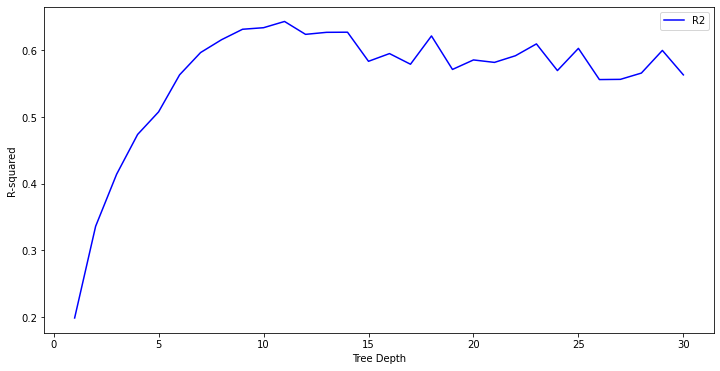

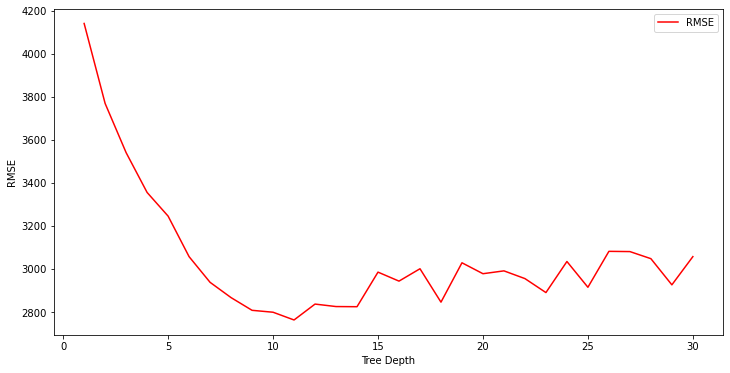

In [55]:
# Identify the optimal tree depth for given data
max_depths = np.linspace(1, 30, 30, endpoint=True)
mse_results = []
r2_results = []

for max_depth in max_depths:
    regressor = DecisionTreeRegressor(max_depth=max_depth, 
                                      random_state=42)
    regressor.fit(X_train_comb, y_train)
    y_pred = regressor.predict(X_test_comb)
    score = performance(y_test, y_pred)
    r2_results.append(score[0])
    mse_results.append(score[1])

plt.figure(figsize=(12, 6))
plt.plot(max_depths, r2_results, 'b', label='R2')
plt.xlabel('Tree Depth')
plt.ylabel('R-squared')
plt.legend()
plt.show()
plt.figure(figsize=(12, 6))
plt.plot(max_depths, mse_results, 'r', label='RMSE')
plt.xlabel('Tree Depth')
plt.ylabel('RMSE')
plt.legend()
plt.show()

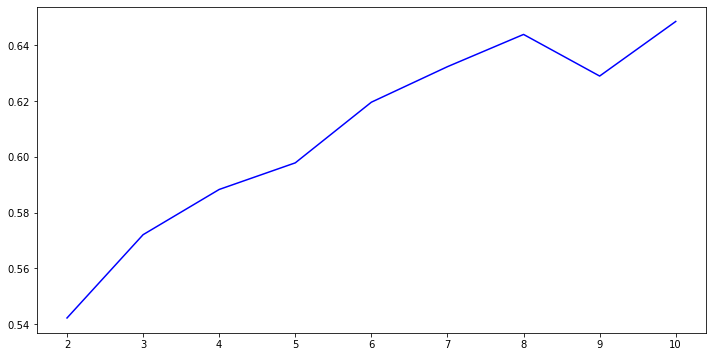

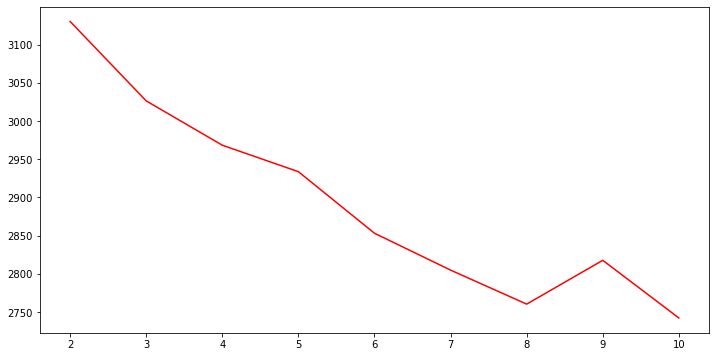

In [56]:
# Identify the optimal minimum split size for given data
min_samples_splits = np.arange(2, 11)
mse_results = []
r2_results = []

for min_samples_split in min_samples_splits:
    regressor = DecisionTreeRegressor(min_samples_split=int(min_samples_split),
                                      random_state=45)
    regressor.fit(X_train_comb, y_train)
    y_pred = regressor.predict(X_test_comb)
    score = performance(y_test, y_pred)
    r2_results.append(score[0])
    mse_results.append(score[1])

plt.figure(figsize=(12, 6))
plt.plot(min_samples_splits, r2_results, 'b', label='R2')
plt.show()
plt.figure(figsize=(12, 6))
plt.plot(min_samples_splits, mse_results, 'r', label='RMSE')
plt.show()

In [57]:
regressor = DecisionTreeRegressor(min_samples_split=2, max_depth=11, random_state=42)
regressor.fit(X_train_comb, y_train)
y_pred = regressor.predict(X_test_comb)
score = performance(y_test, y_pred)
score[0], score[1], regressor

(0.6432248651271761,
 2763.235469098934,
 DecisionTreeRegressor(max_depth=11, random_state=42))

And we see significant improvement with the optimal parameters

### Maybe a KNN Model can do better?

In [58]:
error_rate = []

for i in range(1,40):
    
    knn = KNeighborsRegressor(n_neighbors=i)
    knn.fit(X_train_comb,y_train)
    pred_i = knn.predict(X_test_comb)
    error_rate.append(np.mean(pred_i != y_test))

Text(0, 0.5, 'Error Rate')

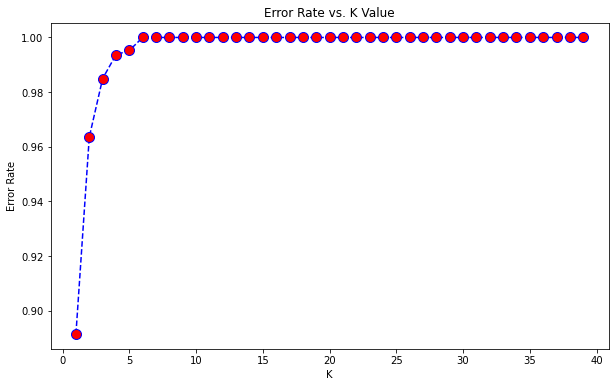

In [59]:
plt.figure(figsize=(10,6))
plt.plot(range(1,40),error_rate,color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

In [60]:
knn = KNeighborsRegressor(n_neighbors=10)
knn.fit(X_train_comb,y_train)
y_pred = knn.predict(X_test_comb)
score = performance(y_test, y_pred)
score[0], score[1], knn

(0.05089714443802407, 4506.892979257636, KNeighborsRegressor(n_neighbors=10))

#### That did not do better at all, let's try a random forest pipeline

### Random Forest PipeLine

In [61]:
pipeline1 = make_pipeline(
    ce.TargetEncoder(),
    SimpleImputer(strategy='median'),
    RandomForestRegressor(max_depth=30,
                                      n_estimators=50, n_jobs=-3,
                                        random_state=30)
)
pipeline1.fit(X_train_comb, y_train)

y_pred = pipeline1.predict(X_test_comb)
print('MAE:', mean_absolute_error(y_test, y_pred))
print('R^2:', r2_score(y_test, y_pred))
print('RMSE:', mean_squared_error(y_test, y_pred, squared=False))

MAE: 1485.9391843736646
R^2: 0.7675847500209521
RMSE: 2230.2467537052116


## GridSearch and Cross Validate for our Random Forest PipeLine

In [62]:
param_grid = {
    'randomforestregressor__max_depth': [2,5,6,10,30,50],
    'randomforestregressor__n_jobs': [10,-5,-3,-1, 0,1, 3,5,10],
    'randomforestregressor__n_estimators': [10, 50, 100, 500 ],
}

In [63]:
rfr =RandomForestRegressor()

In [64]:
pipeline1 = make_pipeline(
    ce.TargetEncoder(),
    SimpleImputer(strategy='median'),
    rfr)

In [65]:
grid_rfr = GridSearchCV(pipeline1, param_grid, cv=5, n_jobs=1, return_train_score=True)

In [66]:
results_rfr = grid_rfr.fit(X_train_comb, y_train)

/Users/avijames/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/avijames/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/avijames/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/avijames/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/avijames/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 966, in __call__
    n_jobs = self._initialize_backend()
  File "/Users/avijames/anaconda3/lib/python3.8/site-packages/joblib/parallel

/Users/avijames/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/avijames/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/avijames/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/avijames/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/avijames/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 966, in __call__
    n_jobs = self._initialize_backend()
  File "/Users/avijames/anaconda3/lib/python3.8/site-packages/joblib/parallel

/Users/avijames/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/avijames/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/avijames/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/avijames/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/avijames/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 966, in __call__
    n_jobs = self._initialize_backend()
  File "/Users/avijames/anaconda3/lib/python3.8/site-packages/joblib/parallel

/Users/avijames/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/avijames/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/avijames/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/avijames/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/avijames/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 966, in __call__
    n_jobs = self._initialize_backend()
  File "/Users/avijames/anaconda3/lib/python3.8/site-packages/joblib/parallel

/Users/avijames/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/avijames/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/avijames/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/avijames/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/avijames/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 966, in __call__
    n_jobs = self._initialize_backend()
  File "/Users/avijames/anaconda3/lib/python3.8/site-packages/joblib/parallel

/Users/avijames/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/avijames/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/avijames/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/avijames/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/avijames/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 966, in __call__
    n_jobs = self._initialize_backend()
  File "/Users/avijames/anaconda3/lib/python3.8/site-packages/joblib/parallel

/Users/avijames/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/avijames/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/avijames/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/avijames/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/avijames/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 966, in __call__
    n_jobs = self._initialize_backend()
  File "/Users/avijames/anaconda3/lib/python3.8/site-packages/joblib/parallel

/Users/avijames/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/avijames/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/avijames/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/avijames/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/avijames/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 966, in __call__
    n_jobs = self._initialize_backend()
  File "/Users/avijames/anaconda3/lib/python3.8/site-packages/joblib/parallel

/Users/avijames/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/avijames/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/avijames/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/avijames/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/avijames/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 966, in __call__
    n_jobs = self._initialize_backend()
  File "/Users/avijames/anaconda3/lib/python3.8/site-packages/joblib/parallel

/Users/avijames/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/avijames/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/avijames/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/avijames/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/avijames/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 966, in __call__
    n_jobs = self._initialize_backend()
  File "/Users/avijames/anaconda3/lib/python3.8/site-packages/joblib/parallel

/Users/avijames/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Users/avijames/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Users/avijames/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Users/avijames/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worke

/Users/avijames/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Users/avijames/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Users/avijames/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Users/avijames/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to n

/Users/avijames/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/avijames/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/avijames/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/avijames/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/avijames/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 966, in __call__
    n_jobs = self._initialize_backend()
  File "/Users/avijames/anaconda3/lib/python3.8/site-packages/joblib/parallel

/Users/avijames/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Users/avijames/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/avijames/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/avijames/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/avijames/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_

/Users/avijames/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.34275066 0.34102205 0.35143791 0.3420939         nan 0.34622051
 0.34134588 0.3471358  0.34403107 0.34591097 0.34519011 0.34715841
 0.34578331        nan 0.34480729 0.34445971 0.34662728 0.34765405
 0.34651955 0.34620133 0.34772027 0.34527143        nan 0.34499755
 0.34743888 0.34466015 0.34496185 0.34647201 0.34734587 0.34573735
 0.34707213        nan 0.34583888 0.34632156 0.34649298 0.34613296
 0.56670891 0.56531909 0.5697565  0.57399056        nan 0.57094322
 0.56353483 0.5634064  0.57667792 0.57651665 0.57704364 0.57745372
 0.57780171        nan 0.58059959 0.57655527 0.57843169 0.57565513
 0.57873646 0.5773822  0.58018586 0.5776063         nan 0.5776464
 0.57460585 0.57785189 0.57831294 0.58050629 0.57886061 0.578594
 0.57815804        nan 0.5793093  0.57998822 0.57931612 0.57847262
 0.62162982 0.62003968 0.63039005 0.62047334 

In [67]:
results_rfr.best_params_

{'randomforestregressor__max_depth': 30,
 'randomforestregressor__n_estimators': 100,
 'randomforestregressor__n_jobs': -5}

## Using the best parameters to make the finished pipeline

In [68]:
pipeline2 = make_pipeline(
    ce.TargetEncoder(),
    SimpleImputer(strategy='median'),
    RandomForestRegressor(max_depth=30,
                                      n_estimators=100, n_jobs=-5,
                                        random_state=30))

In [69]:
pipeline2.fit(X_train_comb, y_train)

y_pred = pipeline2.predict(X_test_comb)
print('MAE:', mean_absolute_error(y_test, y_pred))
print('R^2:', r2_score(y_test, y_pred))
print('RMSE:', mean_squared_error(y_test, y_pred, squared=False))

MAE: 1481.0566153584805
R^2: 0.7691879284355592
RMSE: 2222.541427463498


### Realy Solid with a 77% R-Squared and RMSE of $2,222

## XGBoost Regression with Pipeline

In [70]:
pipeline4 = make_pipeline(
    ce.TargetEncoder(),
    SimpleImputer(strategy='median'),
    XGBRegressor(learning_rate=0.1,
                max_depth=6,
                min_child_weight=2,
                n_estimators =100,
                subsample=0.9))

pipeline4.fit(X_train_comb, y_train)
y_pred = pipeline4.predict(X_test_comb)
print('MAE:', mean_absolute_error(y_test, y_pred))
print('R^2:', r2_score(y_test, y_pred))
print('RMSE:', mean_squared_error(y_test, y_pred, squared=False))

MAE: 1481.042324253572
R^2: 0.7906198932981898
RMSE: 2116.8413667604714


### Very solid results, let's try with a grid search and cross validation

## Let's try with a Grid Search Cross Validate

In [71]:
param_grid = {
    'xgbregressor__learning_rate': [0.1, 0.5, 1],
    'xgbregressor__max_depth': [2,5,6,10],
    'xgbregressor__min_child_weight': [1, 2, 3],
    'xgbregressor__subsample': [0.5, 0.7, .9],
    'xgbregressor__n_estimators': [10, 50, 100, 500 ],
}

In [72]:
xgb =XGBRegressor()

In [73]:
pipeline5 = make_pipeline(
    ce.TargetEncoder(),
    SimpleImputer(strategy='median'),
    xgb)

In [74]:
grid_clf = GridSearchCV(pipeline5, param_grid, cv=5, n_jobs=1, return_train_score=True)

In [75]:
results = grid_clf.fit(X_train_comb, y_train)

In [76]:
results.best_params_

{'xgbregressor__learning_rate': 0.1,
 'xgbregressor__max_depth': 6,
 'xgbregressor__min_child_weight': 1,
 'xgbregressor__n_estimators': 100,
 'xgbregressor__subsample': 0.9}

## Using the best parameters to make the finished pipeline

In [78]:
pipeline6 = make_pipeline(
    ce.TargetEncoder(),
    SimpleImputer(strategy='median'),
    XGBRegressor(learning_rate=0.1,
                max_depth=6,
                min_child_weight=1,
                n_estimators =100,
                subsample=0.9))

pipeline6.fit(X_train_comb, y_train)
y_pred = pipeline6.predict(X_test_comb)
print('MAE:', mean_absolute_error(y_test, y_pred))
print('R^2:', r2_score(y_test, y_pred))
print('RMSE:', mean_squared_error(y_test, y_pred, squared=False))

MAE: 1484.6020720613362
R^2: 0.7861867404483275
RMSE: 2139.133665010211
